In [ ]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.utils.class_weight import compute_sample_weight

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [206]:
df = pd.read_csv("C:/Users/Настя/YandexDisk-n4skolesnikova/HSE 4th year/Graduation Thesis/ACCIDENT_LEVEL_DATA.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)
df.head()

(440132, 79)


,COORD_L,COORD_W,dor_k,s_dtp,RTA_vehicle_number,RTA_participants_number,RTA_number,number_of_deaths,number_of_wounded,any_TV_technical_failures,...,accident_month,accident_weekday,accident_season,is_weekend,RTA_hour,is_night,is_peak_hour,severity,severity_detailed,is_toll
0,81.151944,53.740000,5.0,610,1,3,161242174,0,3,0,...,1,5,1,1,9,0,1,medium,injury_with_hospitalization,0
1,85.018056,51.684444,6.0,200,2,3,161105683,0,2,0,...,1,4,1,0,14,0,0,medium,injury_with_hospitalization,0
2,81.250000,53.818056,5.0,210,2,3,161763431,0,1,0,...,1,4,1,0,17,0,1,light,injury_no_hospitalization,0
3,51.000000,84.000000,7.0,610,1,2,160331994,0,1,0,...,1,5,1,1,19,0,0,light,injury_no_hospitalization,0
4,84.000000,53.000000,7.0,600,1,2,160213415,1,1,0,...,1,4,1,0,21,0,0,severe,death_at_scene,0


In [207]:
df.columns

Index(['COORD_L', 'COORD_W', 'dor_k', 's_dtp', 'RTA_vehicle_number',
       'RTA_participants_number', 'RTA_number', 'number_of_deaths',
       'number_of_wounded', 'any_TV_technical_failures',
       'any_non_private_vehicles', 'any_russian_vehicles',
       'any_white_vehicles', 'any_black_vehicles', 'any_colored_vehicles',
       'any_drunk_drivers', 'any_female_drivers', 'any_escaped_participants',
       'any_concomitant_traffic_violations',
       'any_injuries_without_safety_belt', 'num_drunk_participants',
       'num_child_restraints', 'num_cyclists', 'num_pedestrians',
       'min_vehicles_age', 'max_vehicles_age', 'avg_vehicles_age',
       'num_A_class_vehicles', 'num_B_class_vehicles', 'num_C_class_vehicles',
       'num_D_class_vehicles', 'num_E_class_vehicles', 'num_S_class_vehicles',
       'num_non_car_vehicles', 'num_front_wheel_drive_vehicles',
       'num_rear_wheel_drive_vehicles', 'num_four_wheel_drive_vehicles',
       'num_guilty_objects', 'share_guilty_vehicles

In [208]:
print(f"Final check for the gaps: {df.isna().any().sum()} gaps")

Final check for the gaps: 0 gaps


#### Create DataFrame for testing hypotheses.

In [209]:
df['severity'].unique()

array(['medium', 'light', 'severe'], dtype=object)

In [210]:
# manually encode target

replace_map = {
    'light': '1',
    'medium': '2',
    'severe': '3'
}

df['severity_encode'] = df['severity'].replace(replace_map)
df['severity_encode'] = df['severity_encode'].astype(int)
df['severity_encode'].unique()

array([2, 1, 3])

In [211]:
df_hypoth = df.drop(columns=['severity_detailed', 'severity', 'num_fatal_traffic_violations'])

# Econometrics

## Multinomial Logit (MNL) regression

Earlier, a class imbalance was found in the 'is_toll' variable: the positive class makes up less than 7% of the entire dataset. Therefore, the results of hypothesis testing on such data will not be representative.  
To address the class imbalance problem, we will try two methods:

1. Balancing using undersampling  
2. Balancing using class weighting

### 1. undersampling 

In [212]:
df_balanced = pd.concat([
    df_hypoth[df_hypoth['is_toll'] == 1],
    df_hypoth[df_hypoth['is_toll'] == 0].groupby('severity_encode').apply(
        lambda x: x.sample(n=(df_hypoth[df_hypoth['is_toll'] == 1]['severity_encode'] == x.name).sum(),
                          random_state=42)
    ).reset_index(drop=True)
])

Let's start the analysis by building a baseline model that includes the `'is_toll'` variable along with key factors related to the road environment and driver experience.

In [213]:
formula = 'severity_encode ~ is_toll + drivers_avg_experience + guilty_drivers_avg_experience\
                + lighting_cat + road_object_type_cat + dor_z_cat + factor_cat'

model = smf.mnlogit(formula, data=df_balanced)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 1.037139
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:        severity_encode   No. Observations:                59080
Model:                        MNLogit   Df Residuals:                    59064
Method:                           MLE   Df Model:                           14
Date:                Sun, 20 Apr 2025   Pseudo R-squ.:                0.006764
Time:                        12:59:41   Log-Likelihood:                -61274.
converged:                       True   LL-Null:                       -61691.
Covariance Type:            nonrobust   LLR p-value:                4.535e-169
            severity_encode=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.1101      0.098     -1.127      0.

The coefficient for `is_toll` in medium-severity crashes (severity_encode = 2) is 0.0649 and statistically significant (p < 0.001), indicating a higher likelihood of medium-severity crashes compared to minor ones on toll roads. However, for severe crashes (severity_encode = 3), the `is_toll` coefficient is negative (−0.0496) and borderline significant (p ≈ 0.073).  
Therefore, **Hypothesis 2.1 is partially supported**: medium-severity crashes are statistically more likely than minor ones on toll roads, but no significant increase is observed for severe outcomes.

The next step is to shift the focus from the external environment to behavioral and regulatory aspects of crashes, including traffic violations and the presence of drunk drivers. This will allow us to explore an alternative explanation for the observed differences.

In [214]:
formula = 'severity_encode ~ is_toll + speeding + signal_violation + wrong_way_driving\
                + any_drunk_drivers + num_drunk_participants + pedestrian_related'

model = smf.mnlogit(formula, data=df_balanced)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 1.017238
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:        severity_encode   No. Observations:                59080
Model:                        MNLogit   Df Residuals:                    59064
Method:                           MLE   Df Model:                           14
Date:                Sun, 20 Apr 2025   Pseudo R-squ.:                 0.02582
Time:                        12:59:42   Log-Likelihood:                -60098.
converged:                       True   LL-Null:                       -61691.
Covariance Type:            nonrobust   LLR p-value:                     0.000
     severity_encode=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0519      0.017     -3.047      0.002      -0.085      

`'is_toll'` shows a positive and statistically significant effect for both medium-severity crashes (coef = 0.0619, p < 0.001) and severe crashes (coef = 0.1602, p < 0.001). This means that on toll roads, the likelihood of more severe outcomes compared to minor ones is significantly higher, which **supports Hypothesis 2.1** in this model specification.

Next, environmental factors, vehicle technical characteristics, and participant behavior should be combined into a single model, which brings the analysis closer to a more comprehensive assessment of the `'is_toll'` effect.

In [215]:
formula = 'severity_encode ~ is_toll\
          + num_drunk_participants + guilty_drivers_avg_experience\
          + share_guilty_vehicles\
          + lighting_cat + road_object_type_cat\
          + speeding + signal_violation + pedestrian_related + wrong_way_driving\
          + num_front_wheel_drive_vehicles + avg_vehicles_age\
          + dor_z_cat + DTPV_cat + OBJ_DTP_cat + factor_cat'


model = smf.mnlogit(formula, data=df_balanced)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 1.006955
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:        severity_encode   No. Observations:                59080
Model:                        MNLogit   Df Residuals:                    59046
Method:                           MLE   Df Model:                           32
Date:                Sun, 20 Apr 2025   Pseudo R-squ.:                 0.03567
Time:                        12:59:45   Log-Likelihood:                -59491.
converged:                       True   LL-Null:                       -61691.
Covariance Type:            nonrobust   LLR p-value:                     0.000
             severity_encode=2       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         39.1559      2.767     14.151     

The coefficient for `'is_toll'` is positive and statistically significant for both medium-severity crashes (coef = 0.1272, p < 0.001) and severe crashes (coef = 0.0728, p = 0.012).  
Thus, the model confidently **confirms Hypothesis 2.1**: the likelihood of both medium and severe crashes is higher on toll roads compared to minor ones when controlling for the full set of factors.

### 2. sample weights

In [ ]:
sample_weights = compute_sample_weight(class_weight='balanced', y=df_hypoth['is_toll'])
df_weighted = df_hypoth.loc[df_hypoth.index.repeat(sample_weights.round().astype(int))]

X = df_weighted[[
    'is_toll', 'RTA_vehicle_number', 'RTA_participants_number',
    'num_drunk_participants', 'guilty_drivers_avg_experience',
    'drivers_avg_experience', 'share_guilty_vehicles',
    'lighting_cat', 'road_object_type_cat', 'speeding', 'signal_violation',
    'pedestrian_related', 'wrong_way_driving', 'num_front_wheel_drive_vehicles',
    'avg_vehicles_age', 'dor_z_cat', 'DTPV_cat', 'OBJ_DTP_cat', 'factor_cat'
]]

X = sm.add_constant(X)

y = df_weighted['severity_encode']

model = sm.MNLogit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.987080
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:        severity_encode   No. Observations:               617372
Model:                        MNLogit   Df Residuals:                   617332
Method:                           MLE   Df Model:                           38
Date:                Sun, 20 Apr 2025   Pseudo R-squ.:                 0.04488
Time:                        13:00:10   Log-Likelihood:            -6.0940e+05
converged:                       True   LL-Null:                   -6.3803e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
             severity_encode=2       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             28.8096      0.816     35.298     

The coefficient for `'is_toll'` is positive and highly significant for both medium-severity crashes (coef = 0.2600, p < 0.001) and severe crashes (coef = 0.2564, p < 0.001), providing strong support for Hypothesis 2.1.  
The significance of `is_toll` remains even after controlling for more than 15 different predictors, which confirms the robustness of the toll road effect.

_To test the robustness of the results, a series of models was estimated with the gradual inclusion of variables (on a balanced subsample). The weighted model was built using the broadest specification, reflecting the full range of available factors, which allowed for the most comprehensive view of the toll road’s impact on crash severity._

# Machine Learning

## Random Forest Classifier 

In [217]:
df_hypoth.columns

Index(['COORD_L', 'COORD_W', 'dor_k', 's_dtp', 'RTA_vehicle_number',
       'RTA_participants_number', 'RTA_number', 'number_of_deaths',
       'number_of_wounded', 'any_TV_technical_failures',
       'any_non_private_vehicles', 'any_russian_vehicles',
       'any_white_vehicles', 'any_black_vehicles', 'any_colored_vehicles',
       'any_drunk_drivers', 'any_female_drivers', 'any_escaped_participants',
       'any_concomitant_traffic_violations',
       'any_injuries_without_safety_belt', 'num_drunk_participants',
       'num_child_restraints', 'num_cyclists', 'num_pedestrians',
       'min_vehicles_age', 'max_vehicles_age', 'avg_vehicles_age',
       'num_A_class_vehicles', 'num_B_class_vehicles', 'num_C_class_vehicles',
       'num_D_class_vehicles', 'num_E_class_vehicles', 'num_S_class_vehicles',
       'num_non_car_vehicles', 'num_front_wheel_drive_vehicles',
       'num_rear_wheel_drive_vehicles', 'num_four_wheel_drive_vehicles',
       'num_guilty_objects', 'share_guilty_vehicles

In [218]:
# Разделяем данные
df_toll = df_hypoth[df_hypoth['is_toll'] == 1]
df_free = df_hypoth[df_hypoth['is_toll'] == 0]

# Целевая переменная
target = 'severity_encode'

# Обучающая и тестовая выборки
features = [
    'RTA_vehicle_number', 'RTA_participants_number', 'num_drunk_participants',
    'guilty_drivers_avg_experience', 'drivers_avg_experience', 'share_guilty_vehicles',
    'lighting_cat', 'road_object_type_cat', 'speeding', 'signal_violation',
    'pedestrian_related', 'wrong_way_driving', 'num_front_wheel_drive_vehicles',
    'avg_vehicles_age', 'dor_z_cat', 'DTPV_cat', 'OBJ_DTP_cat', 'factor_cat'
]

X_toll = df_toll[features]
y_toll = df_toll[target]
X_train_toll, X_test_toll, y_train_toll, y_test_toll = train_test_split(X_toll, y_toll, test_size=0.2, random_state=42)

X_free = df_free[features]
y_free = df_free[target]
X_train_free, X_test_free, y_train_free, y_test_free = train_test_split(X_free, y_free, test_size=0.2, random_state=42)

# Модели
rf_toll = RandomForestClassifier(random_state=42)
rf_toll.fit(X_train_toll, y_train_toll)

rf_free = RandomForestClassifier(random_state=42)
rf_free.fit(X_train_free, y_train_free)

RandomForestClassifier(random_state=42)

In [219]:
from sklearn.metrics import accuracy_score, f1_score

# Предсказания
y_pred_toll = rf_toll.predict(X_test_toll)
y_pred_free = rf_free.predict(X_test_free)

# Оценки
f1_toll = f1_score(y_test_toll, y_pred_toll, average='macro')
f1_free = f1_score(y_test_free, y_pred_free, average='macro')

print("F1 (macro) Toll roads:", f1_toll)
print("F1 (macro) Free roads:", f1_free)

print("Accuracy Toll:", accuracy_score(y_test_toll, y_pred_toll))
print("Accuracy Free:", accuracy_score(y_test_free, y_pred_free))


F1 (macro) Toll roads: 0.43326948748590666
F1 (macro) Free roads: 0.4148449274763523
Accuracy Toll: 0.470209884901828
Accuracy Free: 0.46604318123698535


In [220]:
from xgboost import XGBClassifier

X_toll = df_toll[features]
y_toll = df_toll[target]
X_train_toll, X_test_toll, y_train_toll, y_test_toll = train_test_split(X_toll, y_toll, test_size=0.2, random_state=42)

X_free = df_free[features]
y_free = df_free[target]
X_train_free, X_test_free, y_train_free, y_test_free = train_test_split(X_free, y_free, test_size=0.2, random_state=42)

y_train_toll = y_train_toll - 1
y_test_toll = y_test_toll - 1
y_train_free = y_train_free - 1
y_test_free = y_test_free - 1

# Обучаем модель для платных дорог
xgb_toll = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_toll.fit(X_train_toll, y_train_toll)

# Обучаем модель для бесплатных дорог
xgb_free = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_free.fit(X_train_free, y_train_free)

# Предсказания
y_pred_toll = xgb_toll.predict(X_test_toll)
y_pred_free = xgb_free.predict(X_test_free)

# Оценки
f1_toll = f1_score(y_test_toll, y_pred_toll, average='macro')
f1_free = f1_score(y_test_free, y_pred_free, average='macro')

print("F1 (macro) Toll roads:", f1_toll)
print("F1 (macro) Free roads:", f1_free)

print("Accuracy Toll:", accuracy_score(y_test_toll, y_pred_toll))
print("Accuracy Free:", accuracy_score(y_test_free, y_pred_free))


F1 (macro) Toll roads: 0.4558317528150162
F1 (macro) Free roads: 0.44226487674534587
Accuracy Toll: 0.485104942450914
Accuracy Free: 0.5067158635638525


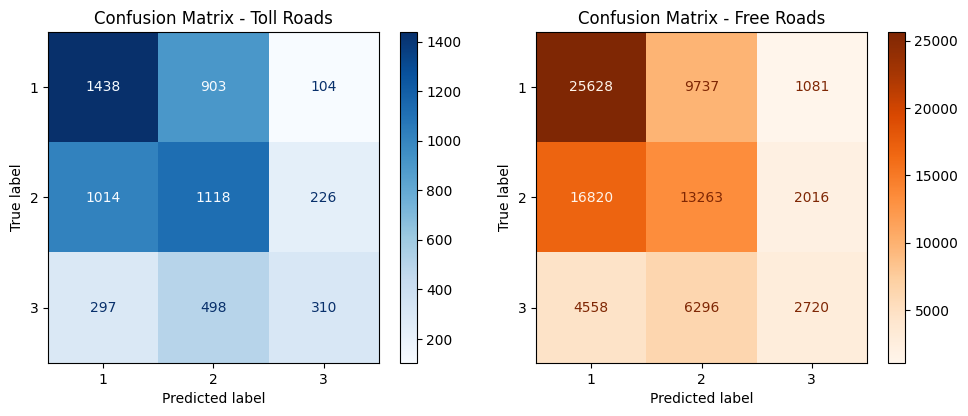

In [221]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_predictions(
    y_test_toll, y_pred_toll, display_labels=[1, 2, 3],
    cmap='Blues', ax=axes[0]
)
axes[0].set_title("Confusion Matrix - Toll Roads")

ConfusionMatrixDisplay.from_predictions(
    y_test_free, y_pred_free, display_labels=[1, 2, 3],
    cmap='Oranges', ax=axes[1]
)
axes[1].set_title("Confusion Matrix - Free Roads")

plt.tight_layout()
plt.show()

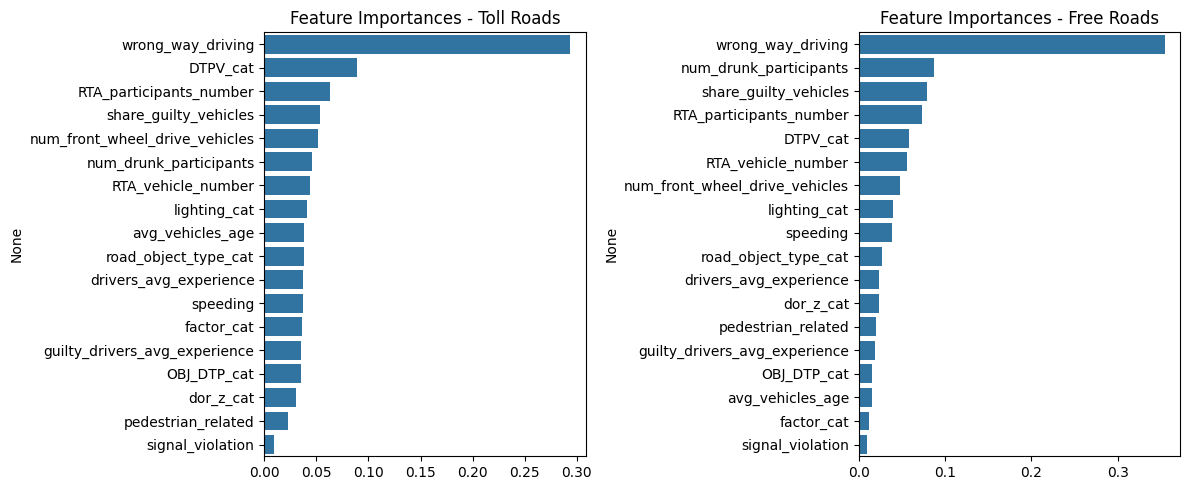

In [222]:
# Feature importances
importances_toll = pd.Series(xgb_toll.feature_importances_, index=features).sort_values(ascending=False)
importances_free = pd.Series(xgb_free.feature_importances_, index=features).sort_values(ascending=False)

# Визуализация
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=importances_toll.values, y=importances_toll.index)
plt.title("Feature Importances - Toll Roads")

plt.subplot(1, 2, 2)
sns.barplot(x=importances_free.values, y=importances_free.index)
plt.title("Feature Importances - Free Roads")

plt.tight_layout()
plt.show()

In [223]:
proba_toll = xgb_toll.predict_proba(X_toll)
proba_free = xgb_free.predict_proba(X_free)

avg_proba_toll = np.mean(proba_toll, axis=0)
avg_proba_free = np.mean(proba_free, axis=0)

print("Toll roads vs free roads\n")
print(f"'Light' severity:  {avg_proba_toll[0]:3f} | {avg_proba_free[0]:3f}")
print(f"'Medium' severity:  {avg_proba_toll[1]:3f} | {avg_proba_free[1]:3f}")
print(f"'Severe' severity:  {avg_proba_toll[2]:3f} | {avg_proba_free[2]:3f}")

Toll roads vs free roads

'Light' severity:  0.403611 | 0.442320
'Medium' severity:  0.411147 | 0.390000
'Severe' severity:  0.185243 | 0.167678


In [225]:
df_hypoth.columns

Index(['COORD_L', 'COORD_W', 'dor_k', 's_dtp', 'RTA_vehicle_number',
       'RTA_participants_number', 'RTA_number', 'number_of_deaths',
       'number_of_wounded', 'any_TV_technical_failures',
       'any_non_private_vehicles', 'any_russian_vehicles',
       'any_white_vehicles', 'any_black_vehicles', 'any_colored_vehicles',
       'any_drunk_drivers', 'any_female_drivers', 'any_escaped_participants',
       'any_concomitant_traffic_violations',
       'any_injuries_without_safety_belt', 'num_drunk_participants',
       'num_child_restraints', 'num_cyclists', 'num_pedestrians',
       'min_vehicles_age', 'max_vehicles_age', 'avg_vehicles_age',
       'num_A_class_vehicles', 'num_B_class_vehicles', 'num_C_class_vehicles',
       'num_D_class_vehicles', 'num_E_class_vehicles', 'num_S_class_vehicles',
       'num_non_car_vehicles', 'num_front_wheel_drive_vehicles',
       'num_rear_wheel_drive_vehicles', 'num_four_wheel_drive_vehicles',
       'num_guilty_objects', 'share_guilty_vehicles

## Прикладная модель

In [227]:
from xgboost import XGBClassifier
import pandas as pd

features = [
    'RTA_vehicle_number', 'RTA_participants_number', 'num_drunk_participants',
    'guilty_drivers_avg_experience', 'drivers_avg_experience', 'share_guilty_vehicles',
    'lighting_cat', 'road_object_type_cat', 'speeding', 'signal_violation',
    'pedestrian_related', 'wrong_way_driving', 'num_front_wheel_drive_vehicles',
    'avg_vehicles_age', 'dor_z_cat', 'DTPV_cat', 'OBJ_DTP_cat', 'factor_cat', 'is_toll'
]

target = 'severity_encode'

X = df_hypoth[features]
y = df_hypoth[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train - 1
y_test = y_test - 1

# Обучение на всех признаках
xgb_full = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_full.fit(X_train, y_train)

# Получаем важности признаков
importances = pd.Series(xgb_full.feature_importances_, index=X_train.columns)
top_10_features = importances.sort_values(ascending=False).head(10).index.tolist()

print("Топ-10 признаков:", top_10_features)

Топ-10 признаков: ['wrong_way_driving', 'num_drunk_participants', 'RTA_participants_number', 'share_guilty_vehicles', 'RTA_vehicle_number', 'DTPV_cat', 'num_front_wheel_drive_vehicles', 'lighting_cat', 'speeding', 'is_toll']


In [229]:
X_train_top10 = X_train[top_10_features]
X_test_top10 = X_test[top_10_features]

xgb_top10 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_top10.fit(X_train_top10, y_train)

# Предсказания
y_pred_full = xgb_full.predict(X_test)
y_pred_top10 = xgb_top10.predict(X_test_top10)


print("Полная модель:")
print("F1 (macro):", f1_score(y_test, y_pred_full, average='macro'))
print("Accuracy:", accuracy_score(y_test, y_pred_full))

print("\nМодель на топ-10 признаках:")
print("F1 (macro):", f1_score(y_test, y_pred_top10, average='macro'))
print("Accuracy:", accuracy_score(y_test, y_pred_top10))

Полная модель:
F1 (macro): 0.4397541607996363
Accuracy: 0.503266043373056

Модель на топ-10 признаках:
F1 (macro): 0.4239368885165024
Accuracy: 0.49384847830779194


Уменьшение количества признаков не дало прироста качества. Попробуем, наоборот, увеличить количество признаков.

In [230]:
features = df_hypoth.columns.to_list()

drop_features = [
    'severity_encode',          # целевая переменная
    'number_of_deaths',
    'number_of_wounded',
    's_dtp',
    'RTA_number',
    'COORD_L', 'COORD_W',
    'min_vehicles_age',
    'max_vehicles_age',
    'num_guilty_objects',
    'accident_year',
    'accident_month'
]

features = [col for col in df_hypoth.columns if col not in drop_features]

X = df_hypoth[features]
y = df_hypoth['severity_encode'] - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_full = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_full.fit(X_train, y_train)

y_pred_full = xgb_full.predict(X_test)

print("F1 (macro):", f1_score(y_test, y_pred_full, average='macro'))
print("Accuracy:", accuracy_score(y_test, y_pred_full))

F1 (macro): 0.4690227410598224
Accuracy: 0.519158894430118


In [234]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_full = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_full.fit(X_train_scaled, y_train)

y_pred_full = xgb_full.predict(X_test_scaled)

print("F1 (macro):", f1_score(y_test, y_pred_full, average='macro'))
print("Accuracy:", accuracy_score(y_test, y_pred_full))

F1 (macro): 0.469688099939797
Accuracy: 0.5197496222749838


<Axes: >

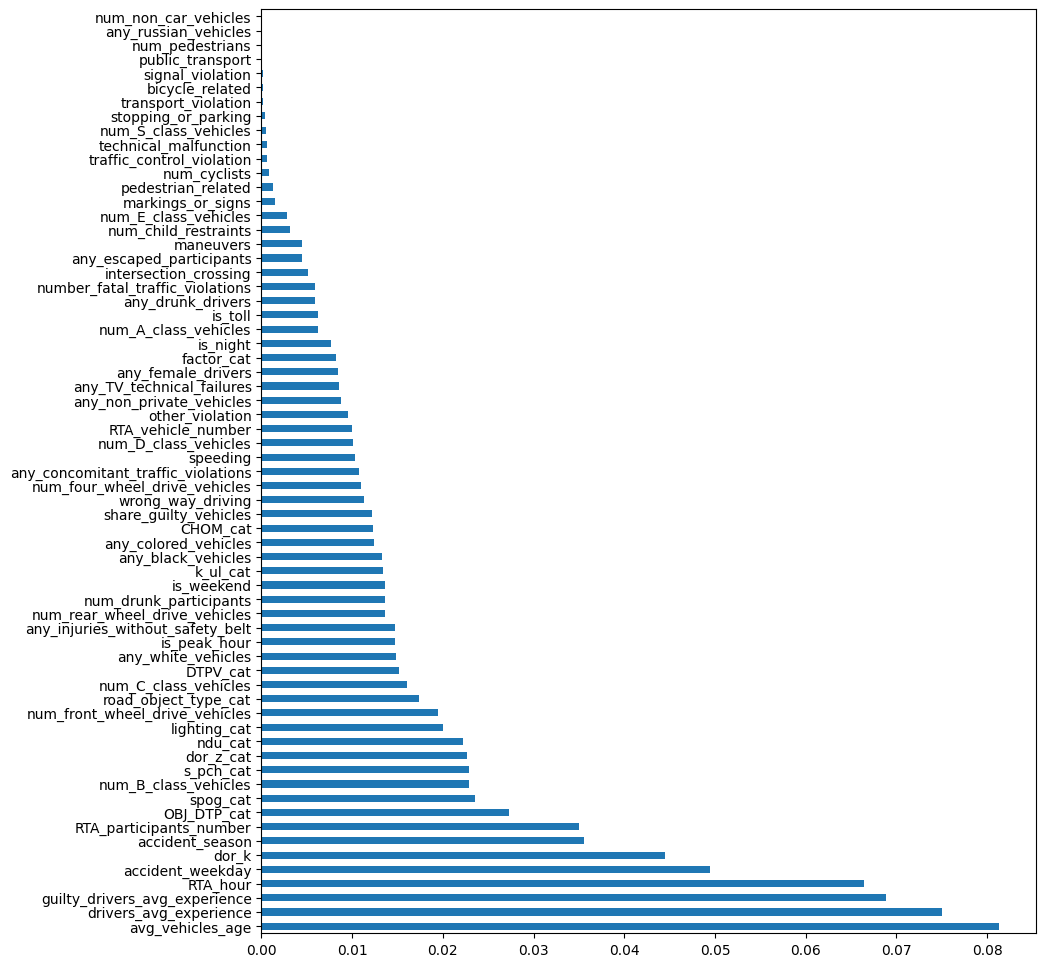

In [254]:
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns)
feat_importances.sort_values(ascending=False).head(X_train.shape[1]).plot(kind='barh', figsize=(10, 12))

In [262]:
threshold = 0.01

# Важности признаков
importances = model.feature_importances_
feature_names = X_train.columns

# DataFrame с важностями
importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Отфильтруем неважные признаки, кроме 'is_toll'
low_importance_features = importances_df[
    (importances_df['importance'] < threshold) & 
    (importances_df['feature'] != 'is_toll')
]['feature'].tolist()

X_train_filtered = X_train.drop(columns=low_importance_features)
X_test_filtered = X_test.drop(columns=low_importance_features)

In [263]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

xgb_full = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_full.fit(X_train_scaled, y_train)

y_pred_full = xgb_full.predict(X_test_scaled)

print("F1 (macro):", f1_score(y_test, y_pred_full, average='macro'))
print("Accuracy:", accuracy_score(y_test, y_pred_full))

F1 (macro): 0.46503713532597013
Accuracy: 0.5160689333954355
